# RLCD on the ball catching problem

In [34]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import heapq

In [35]:
class PartialModel:
    # Assumed that number of actions is same for all states which is true for the machine replacement problem
    def __init__(self, num_states, num_actions, M, quality_interpolation_factor, quality_adjustment_coeff):
        self.num_states = num_states
        self.num_actions = num_actions
        self.T = np.ones((num_states, num_actions, num_states)) / num_states
        self.R = np.zeros((num_states, num_actions))
        self.N = np.zeros((num_states, num_actions))
        self.M = M
        self.quality_trace = 0 # Initial quality
        self.quality_interpolation_factor = quality_interpolation_factor
        self.quality_adjustment_coeff = quality_adjustment_coeff
        self.R_max = 0
        self.R_min = 0

    def update_quality(self, state, action, reward, next_state):
        c = self.N[state, action] / self.M
        delta_R = (reward - self.R[state, action]) / (self.N[state, action] + 1)
        self.R_max = max(self.R_max, self.R[state, action])
        self.R_min = min(self.R_min, self.R[state, action])

        Z_R = 1 / (self.R_max - self.R_min) if self.R_max > self.R_min else 1.0
        e_R = 1 - 2 * (Z_R * delta_R**2)

        delta_T_sum_sq = 0
        for k in range(self.num_states):
            if k == next_state:
                delta_T = (1 - self.T[state, action, k]) / (self.N[state, action] + 1)
            else:
                delta_T = -self.T[state, action, k] / (self.N[state, action] + 1)
            delta_T_sum_sq += delta_T**2

        Z_T = 0.5 * (self.N[state, action] + 1)**2
        e_T = 1 - 2 * (Z_T * delta_T_sum_sq)

        e = c * (self.quality_interpolation_factor * e_R +
                (1 - self.quality_interpolation_factor) * e_T)

        self.quality_trace = self.quality_trace + self.quality_adjustment_coeff * (e - self.quality_trace)

    def update_model(self, state, action, reward, next_state):
        delta_R = (reward - self.R[state, action]) / (self.N[state, action] + 1)
        self.R[state, action] += delta_R

        for k in range(self.num_states):
            if k == next_state:
                delta_T = (1 - self.T[state, action, k]) / (self.N[state, action] + 1)
            else:
                delta_T = -self.T[state, action, k] / (self.N[state, action] + 1)
            self.T[state, action, k] += delta_T

        self.N[state, action] = min(self.N[state, action] + 1, self.M)

    def get_quality(self):
        return self.quality_trace

    def get_reward(self, state, action):
        return self.R[state, action]

    def get_next_state(self, state, action):
        return self.T[state, action]

In [36]:
class DynaAgent: #* needs to be modified for this problem. does not work yet
    def __init__(self, state_space_size, action_space_size, model,
                 learning_rate=0.1, discount_factor=0.9, epsilon=0.1,
                 planning_steps=5):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.model = model

        self.q_table = np.zeros((state_space_size, action_space_size))
        self.visited_state_actions = set()  # Track visited (state, action) pairs

    def is_visited(self, state, action):
        if (state, action) in self.visited_state_actions:
            return True
        return False

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_space_size)
        else:
            return np.argmin(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        transition_probs = self.model.T[state, action]
        # if transition_probs:
        rewards = self.model.R[state, action]
        expected_q = 0.0
        for ns in range(self.state_space_size):
            best_next_action = np.argmin(self.q_table[ns])
            expected_q += transition_probs[ns] * (rewards + self.gamma * self.q_table[ns, best_next_action])
        self.q_table[state, action] = expected_q

    def planning(self):
        for _ in range(self.planning_steps):
            if not self.visited_state_actions:
                break
            state, action = random.choice(list(self.visited_state_actions))
            next_state = np.random.choice(self.model.T.shape[2], p=self.model.T[state, action])
            reward = self.model.R[state, action]
            self.update_q_table(state, action, reward, next_state)

    def learn(self, state, action, reward, next_state):
        if not self.is_visited(state, action):
            self.visited_state_actions.add((state, action))

        self.update_q_table(state, action, reward, next_state)

        self.planning()

In [37]:
class PrioritizedSweeping:
    def __init__(self, num_states, num_actions, model, gamma=0.9, alpha=0.1, theta=0.01, planning_steps=5):
        self.num_states = num_states
        self.num_actions = num_actions
        self.model = model
        self.gamma = gamma
        self.alpha = alpha
        self.theta = theta
        self.planning_steps = planning_steps

        self.Q = np.zeros((num_states, num_actions))
        self.predecessors = defaultdict(set)
        self.priority_queue = []

    def observe(self, s, a, r, s_next):
        self.predecessors[s_next].add((s, a))
        priority = abs(r + self.gamma * max(self.Q[s_next, :]) - self.Q[s, a])
        if priority > self.theta:
            heapq.heappush(self.priority_queue, (-priority, (s, a)))

    def planning(self):
        steps = 0
        while self.priority_queue and steps < self.planning_steps:
            _, (s, a) = heapq.heappop(self.priority_queue)
            r = self.model.R[s, a]
            transition_probs = self.model.T[s, a]
            expected_q_next = np.sum(transition_probs * np.max(self.Q, axis=1))
            self.Q[s, a] += self.alpha * (r + self.gamma * expected_q_next - self.Q[s, a])

            for s_prev, a_prev in self.predecessors[s]:
                r_prev = self.model.R[s_prev, a_prev]
                transition_probs_prev = self.model.T[s_prev, a_prev]
                expected_q_prev_next = np.sum(transition_probs_prev * np.max(self.Q, axis=1))
                priority = abs(r_prev + self.gamma * expected_q_prev_next - self.Q[s_prev, a_prev])
                if priority > self.theta:
                    heapq.heappush(self.priority_queue, (-priority, (s_prev, a_prev)))

            steps += 1

    def choose_action(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.randint(self.model.num_actions)
        else:
            return np.argmax(self.Q[state])

    def get_policy(self):
        return np.argmax(self.Q, axis=1)

In [38]:
class BallCatchingEnv:
    def __init__(self, grid_size=15, ball_behavior=0):
        self.grid_size = grid_size
        self.action_space = 4  # 0: left, 1: right, 2: down, 3: up
        self.cat_pos = None
        self.ball_pos = None
        self.ball_behavior = ball_behavior
        self.step_count = 0

    def reset(self):
        self.cat_pos = np.array([np.random.randint(self.grid_size), np.random.randint(self.grid_size)])
        self.ball_pos = np.array([np.random.randint(self.grid_size), np.random.randint(self.grid_size)])
        self.step_count = 0
        return self._get_state()

    def set_ball_behavior(self, behavior):
        self.ball_behavior = behavior

    def step(self, action):
        self.step_count += 1

        self.cat_pos = self._move(self.cat_pos, action)

        self.ball_pos = self._move(self.ball_pos, self.ball_behavior)

        done = np.array_equal(self.cat_pos, self.ball_pos)
        reward = 1 if done else 0

        return self._get_state(), reward, done

    def _move(self, pos, direction):
        new_pos = pos.copy()
        if direction == 0:
            new_pos[1] = (pos[1] - 1) % self.grid_size
        elif direction == 1:
            new_pos[1] = (pos[1] + 1) % self.grid_size
        elif direction == 2:
            new_pos[0] = (pos[0] + 1) % self.grid_size
        elif direction == 3:
            new_pos[0] = (pos[0] - 1) % self.grid_size
        return new_pos

    def _get_state(self):
        cat_idx = self.cat_pos[0] * self.grid_size + self.cat_pos[1]
        ball_idx = self.ball_pos[0] * self.grid_size + self.ball_pos[1]
        return cat_idx * (self.grid_size * self.grid_size) + ball_idx

In [39]:
def run_rlcd(E_min = -0.5):
    grid_size = 6
    num_states = (grid_size * grid_size) ** 2
    num_actions = 4

    M = 100
    rho = 0.1
    omega = 0.0

    models = []
    current_model = PartialModel(num_states, num_actions, M, omega, rho)
    models.append(current_model)

    policy_learner = PrioritizedSweeping(num_states, num_actions, current_model)

    env = BallCatchingEnv(grid_size, ball_behavior=0)

    episode_rewards = []
    context_changes = []
    model_qualities = []
    num_models_over_time = []

    contexts = [0, 1, 2, 3, 0, 1, 2, 3]  # left, right, down, up, repeat
    context_duration = 250

    episode = 0
    context_idx = 0
    episodes_in_context = 0

    epsilon = 1

    for episode in tqdm(range(2000)):
        if episodes_in_context >= context_duration and context_idx < len(contexts) - 1:
            context_idx += 1
            episodes_in_context = 0
            env.set_ball_behavior(contexts[context_idx])
            context_changes.append(episode)
            print(f"Context change at episode {episode}: ball behavior = {contexts[context_idx]}")

        state = env.reset()
        episode_reward = 0
        steps = 0
        max_steps = 100

        while steps < max_steps:
            action = policy_learner.choose_action(state, epsilon)

            next_state, reward, done = env.step(action)
            episode_reward += reward

            for model in models:
                model.update_quality(state, action, reward, next_state)

            best_model = max(models, key=lambda m: m.get_quality())

            if best_model.get_quality() < E_min:
                print(f"Creating new model at episode {episode} (quality: {best_model.get_quality():.3f})")
                current_model = PartialModel(num_states, num_actions, M, omega, rho)
                models.append(current_model)
            else:
                current_model = best_model

            current_model.update_model(state, action, reward, next_state)

            policy_learner.observe(state, action, reward, next_state)
            policy_learner.planning()

            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        model_qualities.append(current_model.get_quality())
        num_models_over_time.append(len(models))
        episodes_in_context += 1

        epsilon = max(0.1, epsilon * 0.99)

    return {
        'episode_rewards': episode_rewards,
        'context_changes': context_changes,
        'model_qualities': model_qualities,
        'num_models': num_models_over_time,
        'final_num_models': len(models)
    }


In [40]:
results = run_rlcd()

  0%|          | 0/2000 [00:00<?, ?it/s]

 13%|█▎        | 253/2000 [00:16<01:32, 18.93it/s]

Context change at episode 250: ball behavior = 1


 25%|██▌       | 503/2000 [00:41<02:04, 12.03it/s]

Context change at episode 500: ball behavior = 2


 38%|███▊      | 751/2000 [01:07<01:33, 13.42it/s]

Context change at episode 750: ball behavior = 3


 50%|█████     | 1000/2000 [01:38<01:41,  9.85it/s]

Context change at episode 1000: ball behavior = 0


 62%|██████▎   | 1250/2000 [02:11<02:03,  6.07it/s]

Context change at episode 1250: ball behavior = 1


 75%|███████▍  | 1499/2000 [02:43<01:07,  7.46it/s]

Context change at episode 1500: ball behavior = 2


 87%|████████▋ | 1749/2000 [03:16<00:25,  9.98it/s]

Context change at episode 1750: ball behavior = 3


100%|██████████| 2000/2000 [03:51<00:00,  8.65it/s]


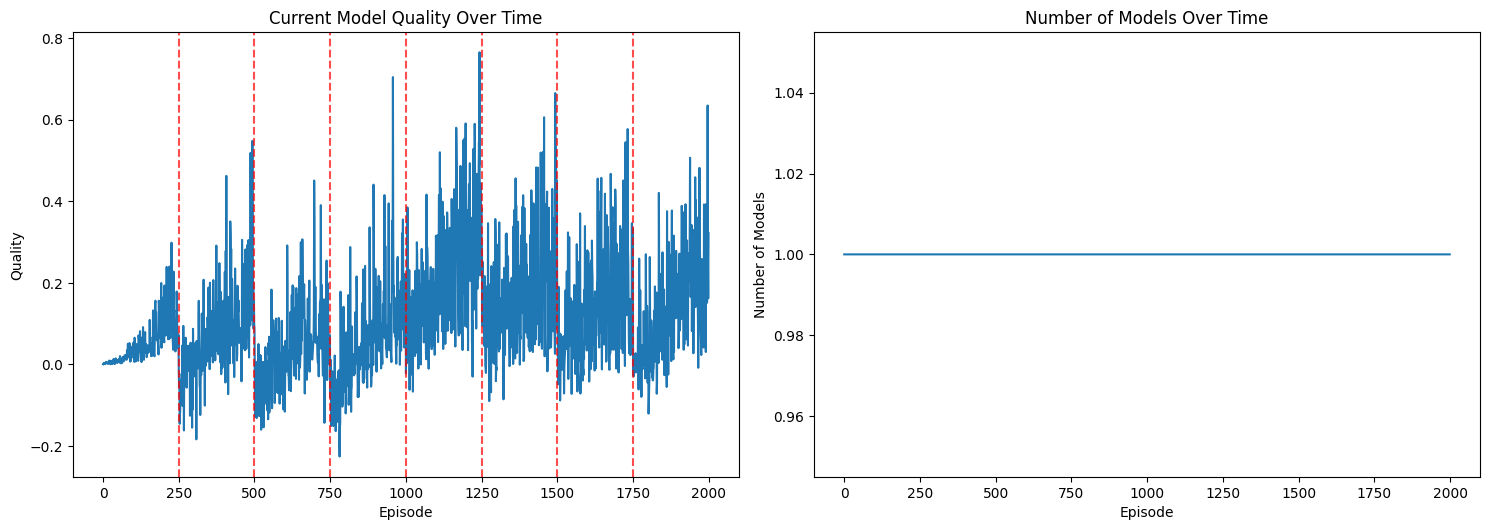

In [41]:
plt.figure(figsize=(15, 10))

# plt.subplot(2, 2, 1)
# plt.plot(results['episode_rewards'])
# for change in results['context_changes']:
#     plt.axvline(x=change, color='r', linestyle='--', alpha=0.7)
# plt.title('Episode Rewards Over Time')
# plt.xlabel('Episode')
# plt.ylabel('Reward')

plt.subplot(2, 2, 1)
plt.plot(results['model_qualities'])
for change in results['context_changes']:
    plt.axvline(x=change, color='r', linestyle='--', alpha=0.7)
plt.title('Current Model Quality Over Time')
plt.xlabel('Episode')
plt.ylabel('Quality')

plt.subplot(2, 2, 2)
plt.plot(results['num_models'])
plt.title('Number of Models Over Time')
plt.xlabel('Episode')
plt.ylabel('Number of Models')

# plt.subplot(2, 2, 4)
# context_rewards = []
# context_duration = 25
# for i in range(0, len(results['episode_rewards']), context_duration):
#     context_rewards.append(np.mean(results['episode_rewards'][i:i+context_duration]))
# plt.bar(range(len(context_rewards)), context_rewards)
# plt.title('Average Reward per Context')
# plt.xlabel('Context')
# plt.ylabel('Average Reward')

plt.tight_layout()
plt.show()

In [42]:
results = run_rlcd(E_min=-0.1)

 13%|█▎        | 251/2000 [00:17<02:31, 11.56it/s]

Context change at episode 250: ball behavior = 1
Creating new model at episode 250 (quality: -0.103)


 25%|██▌       | 500/2000 [00:52<03:16,  7.64it/s]

Context change at episode 500: ball behavior = 2
Creating new model at episode 500 (quality: -0.106)


 37%|███▋      | 749/2000 [01:30<03:32,  5.88it/s]

Context change at episode 750: ball behavior = 3
Creating new model at episode 750 (quality: -0.110)


 50%|████▉     | 999/2000 [02:18<03:41,  4.51it/s]

Context change at episode 1000: ball behavior = 0


 62%|██████▏   | 1249/2000 [03:01<01:56,  6.45it/s]

Context change at episode 1250: ball behavior = 1


 75%|███████▍  | 1498/2000 [03:57<01:34,  5.34it/s]

Context change at episode 1500: ball behavior = 2


 88%|████████▊ | 1750/2000 [04:50<00:53,  4.70it/s]

Context change at episode 1750: ball behavior = 3


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


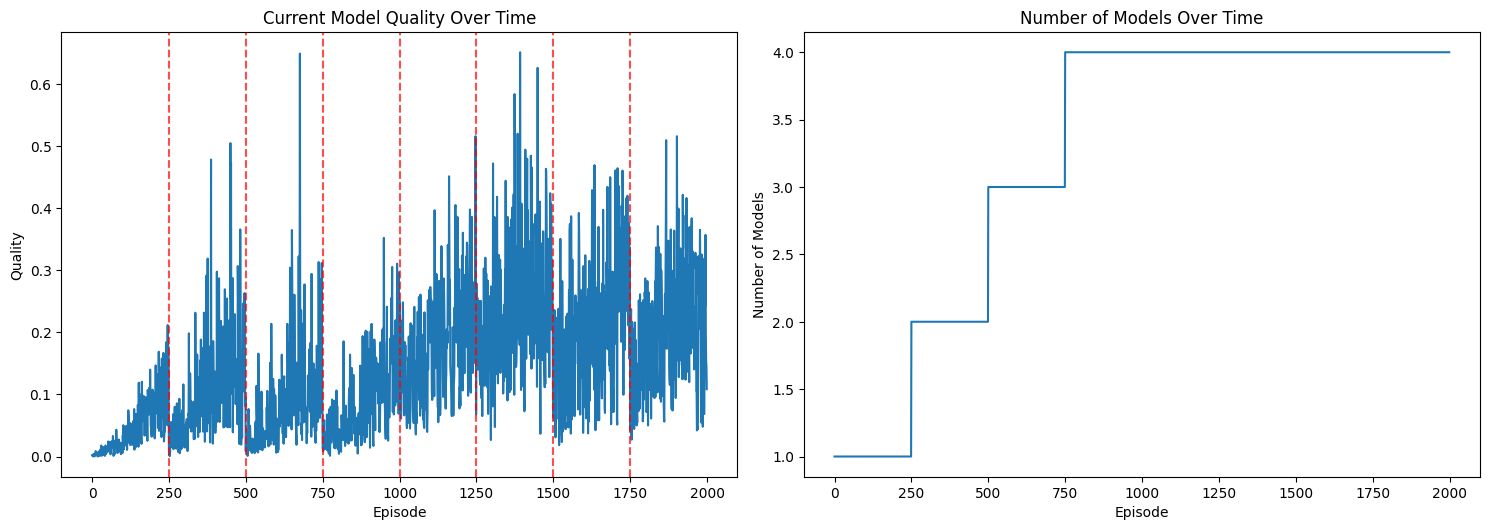

In [43]:
plt.figure(figsize=(15, 10))

# plt.subplot(2, 2, 1)
# plt.plot(results['episode_rewards'])
# for change in results['context_changes']:
#     plt.axvline(x=change, color='r', linestyle='--', alpha=0.7)
# plt.title('Episode Rewards Over Time')
# plt.xlabel('Episode')
# plt.ylabel('Reward')

plt.subplot(2, 2, 1)
plt.plot(results['model_qualities'])
for change in results['context_changes']:
    plt.axvline(x=change, color='r', linestyle='--', alpha=0.7)
plt.title('Current Model Quality Over Time')
plt.xlabel('Episode')
plt.ylabel('Quality')

plt.subplot(2, 2, 2)
plt.plot(results['num_models'])
plt.title('Number of Models Over Time')
plt.xlabel('Episode')
plt.ylabel('Number of Models')

# plt.subplot(2, 2, 4)
# context_rewards = []
# context_duration = 25
# for i in range(0, len(results['episode_rewards']), context_duration):
#     context_rewards.append(np.mean(results['episode_rewards'][i:i+context_duration]))
# plt.bar(range(len(context_rewards)), context_rewards)
# plt.title('Average Reward per Context')
# plt.xlabel('Context')
# plt.ylabel('Average Reward')

plt.tight_layout()
plt.show()